In [1]:
import numpy as np
import operator
%run TreePlotter.ipynb

### 步骤
    （1）给出数据集，计算数据集的信息熵
    （2）根据数据每个特征的不同值分类，计算分类后的信息熵，并与分类前的信息上比较，
    选出信息增益最大的那个特征，作为分类的依据

In [2]:
def caculate_entropy(dataset):
    '''计算数据集的信息熵，度量数据集的无序程度'''
    m = len(dataset)   # 一共有多少数据
    labels_count = {}  # 创建一个字典用于统计每一类的数据个数
    for data in dataset:   
        label = data[-1]                                    #将数据集按照标签进行统计，
        labels_count[label] = labels_count.get(label,0)+1   #结果存为字典
                                                                
    entropy = 0.0
    for key in labels_count.keys():                         #计算信息熵
        prob = float(labels_count[key])/m
        entropy -= prob*np.log2(prob) 
    return entropy

In [3]:
def split_dataset(dataset,axis,values):                      
    '''划分数据集dataset,axis为划分的依据特征,values为需要返回的特征值'''
    reduce_dataset =[]                                  
    for data in dataset:                        
        if data[axis]==values:                  #按照轴axis处取值的不同划分为两类
            reduce_data = data[:axis]           #等于value的一类，否则为另一类
            reduce_data.extend(data[axis+1:])
            reduce_dataset.append(reduce_data)
    return reduce_dataset

In [4]:
def choose_split_feature(dataset):
    '''选择最好的特征来划分数据集'''
    feature_num = len(dataset[0])-1
    base_entropy = caculate_entropy(dataset)     #计算原始数据集的信息熵
    best_info_gain = 0.0;
    best_feature = -1
    
    for i in range(feature_num):
        #对每一个特征进行划分数据集，计算他们的信息增益，取信息增益最大的那个作为最好特征
        feature_list = [data[i] for data in dataset]
        unique_feature = set(feature_list)
        
        new_entropy = 0.0
        for feature in unique_feature:           #对每一个特征
            sub_dataset = split_dataset(dataset,i,feature)
            prob = len(sub_dataset)/float(len(dataset))
            new_entropy += prob*caculate_entropy(sub_dataset)
        info_gain = base_entropy-new_entropy     #获得信息增益
        
        if (info_gain>best_info_gain):          #选出获得最大信息增益的特征
            best_info_gain = info_gain
            best_feature = i
    return best_feature


In [5]:
def majorityCnt(classlist):
    '''若数据集已经处理了所有的属性，但是类标签仍然不是唯一的，则采用多数表决法'''
    class_count = {}
    for vote in classlist:
        class_count[vote] = class_count.get(vote,0)+1
    sort_class_count = sorted(class_count.items(),key=operator.itemgetter(1),reverse=True)
    return sort_class_count[0][0]

In [6]:
def createTree(dataSet,labels):
    '''构建决策树'''
    classList = [example[-1] for example in dataSet]       #创建类标签列表
    if classList.count(classList[0]) == len(classList):    
        #当类标签列表中所有的数据都属于同一类时，停止分离
        return classList[0]
    if len(dataSet[0]) == 1: 
        #当数据中没有可以处理的特征时，采用多数表决法
        return majorityCnt(classList)
    
    bestFeat = choose_split_feature(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(split_dataset(dataSet, bestFeat, value),subLabels)
    return myTree     

In [7]:
def classify(inputTree,featLabels,testVec):
    firstStr = inputTree.keys()[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

In [10]:
def lenses_tree():
    '''隐形眼镜分类'''
    with open('lenses.txt') as f:
        lenses = [inst.strip().split('\t') for inst in f.readlines()]
    lensesLabels = ['age','prescript','astigmatic','tearRate']
    lensesTree = createTree(lenses,lensesLabels)
    return lensesTree

{'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'yes': {'prescript': {'hyper': {'age': {'presbyopic': 'no lenses', 'young': 'hard', 'pre': 'no lenses'}}, 'myope': 'hard'}}, 'no': {'age': {'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}, 'young': 'soft', 'pre': 'soft'}}}}}}


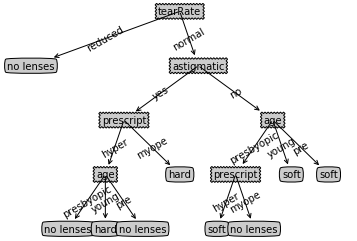

In [11]:
lenses_tree = lenses_tree()
print(lenses_tree)
createPlot(lenses_tree)